## Spam Mail Checker

In [31]:
#Importing all the libraries to be used
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np 
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline    
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from matplotlib.colors import ListedColormap
from sklearn.metrics import precision_score, recall_score, classification_report, accuracy_score, f1_score
from sklearn import metrics 
import joblib

In [2]:
df = pd.read_csv("spam.csv", encoding='ISO-8859-1')
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [3]:
# Drop unnamed columns and rename v1 and v2 
to_drop = ["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"]
df = df.drop(df[to_drop], axis=1)
df.rename(columns={"v1": "Target", "v2": "Text"}, inplace=True)
df.head()

,Target,Text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [4]:
len(df)

5572

In [5]:
df.isna().sum()

Target    0
Text      0
dtype: int64

Text(0.5, 1.0, 'Number of each class of target')

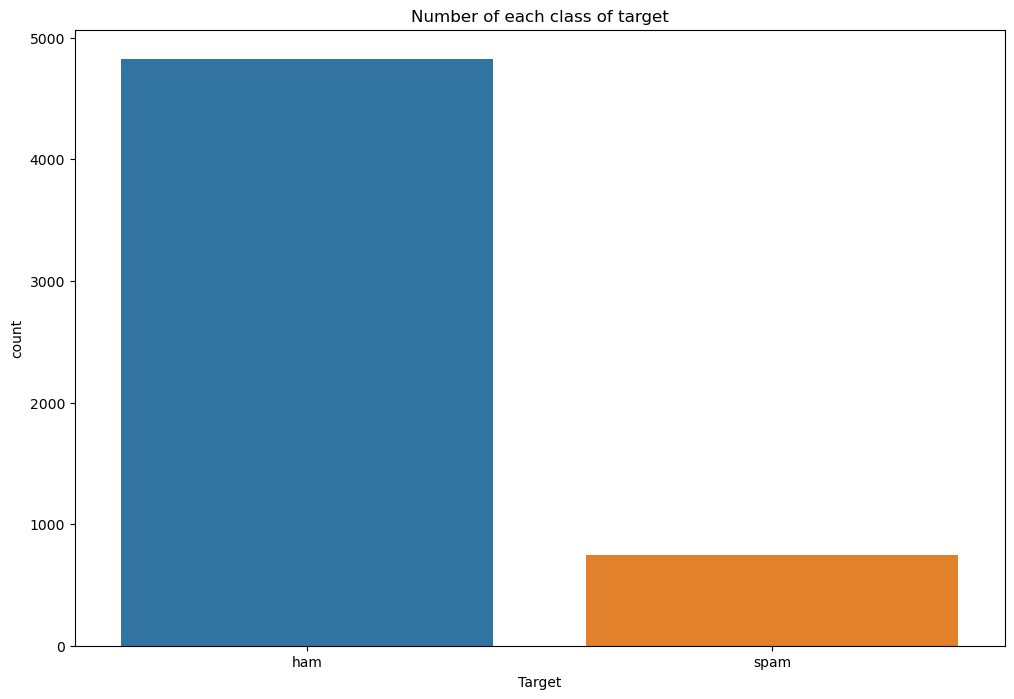

In [6]:
#Data exploration
plt.figure(figsize=(12, 8))
fg = sns.countplot(x=df["Target"])
fg.set_title("Number of each class of target")

In [7]:
#Add columns for no of characters, words and sentences

df["Number of Characters"] = df["Text"].apply(len)
df["No of Words"] = df.apply(lambda row: nltk.word_tokenize(row["Text"]), axis=1).apply(len)
df["No of Sentences"] = df.apply(lambda row: nltk.sent_tokenize(row["Text"]), axis=1).apply(len)

In [8]:
df.head()
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Number of Characters,5572.0,80.118808,59.690841,2.0,36.0,61.0,121.0,910.0
No of Words,5572.0,18.699390,13.741932,1.0,9.0,15.0,27.0,220.0
No of Sentences,5572.0,1.996411,1.520159,1.0,1.0,1.5,2.0,38.0


/Users/toluwase/Documents/spam-ml/env/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/toluwase/Documents/spam-ml/env/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/toluwase/Documents/spam-ml/env/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Figure size 1200x800 with 0 Axes>

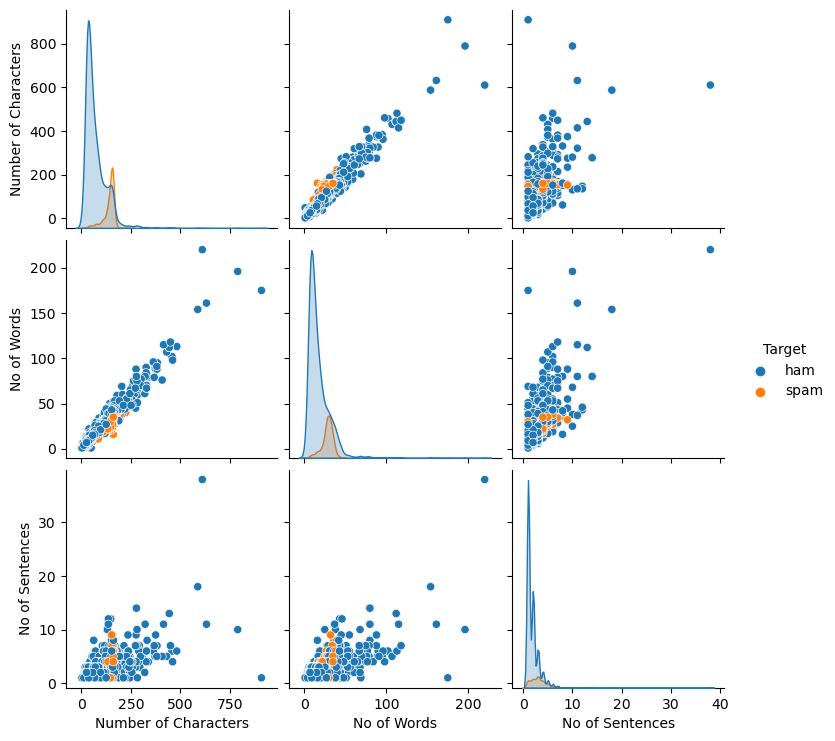

In [9]:
plt.figure(figsize=(12, 8))
fg = sns.pairplot(data=df, hue="Target")

In [10]:
# Data preprocessing
#1. Cleaning text
#2. Tokenization
#3. Removing stopwords
#4. lemmatization

df["Text"][:5]

0    Go until jurong point, crazy.. Available only ...
1                        Ok lar... Joking wif u oni...
2    Free entry in 2 a wkly comp to win FA Cup fina...
3    U dun say so early hor... U c already then say...
4    Nah I don't think he goes to usf, he lives aro...
Name: Text, dtype: object

In [11]:
# Create a function to clean text

def clean_text (text):
    """
    removes none alphabetical text
    """
    sms = re.sub('[^a-zA-Z]', ' ', text)
    sms = sms.lower()
    sms = sms.split()
    sms = " ".join(sms)
    return sms

df["Clean Text"] = df["Text"].apply(clean_text)
df.head()

,Target,Text,Number of Characters,No of Words,No of Sentences,Clean Text
0,ham,"Go until jurong point, crazy.. Available only ...",111,24,2,go until jurong point crazy available only in ...
1,ham,Ok lar... Joking wif u oni...,29,8,2,ok lar joking wif u oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2,free entry in a wkly comp to win fa cup final ...
3,ham,U dun say so early hor... U c already then say...,49,13,1,u dun say so early hor u c already then say
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,15,1,nah i don t think he goes to usf he lives arou...


In [12]:
df["Tokenized Text"] = df.apply(lambda row: nltk.word_tokenize(row["Clean Text"]), axis=1)

In [13]:
df.head()

,Target,Text,Number of Characters,No of Words,No of Sentences,Clean Text,Tokenized Text
0,ham,"Go until jurong point, crazy.. Available only ...",111,24,2,go until jurong point crazy available only in ...,"[go, until, jurong, point, crazy, available, o..."
1,ham,Ok lar... Joking wif u oni...,29,8,2,ok lar joking wif u oni,"[ok, lar, joking, wif, u, oni]"
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2,free entry in a wkly comp to win fa cup final ...,"[free, entry, in, a, wkly, comp, to, win, fa, ..."
3,ham,U dun say so early hor... U c already then say...,49,13,1,u dun say so early hor u c already then say,"[u, dun, say, so, early, hor, u, c, already, t..."
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,15,1,nah i don t think he goes to usf he lives arou...,"[nah, i, don, t, think, he, goes, to, usf, he,..."


In [14]:
# Create a function to remove stopwords

def remove_stopwords(text):
    """
    remove punctuations
    """
    stop_words = set(stopwords.words("english"))
    filtered_text = [word for word in text if word not in stop_words]
    return filtered_text
df["No_stopwords Text"] = df["Tokenized Text"].apply(remove_stopwords)

In [15]:
df.head()

,Target,Text,Number of Characters,No of Words,No of Sentences,Clean Text,Tokenized Text,No_stopwords Text
0,ham,"Go until jurong point, crazy.. Available only ...",111,24,2,go until jurong point crazy available only in ...,"[go, until, jurong, point, crazy, available, o...","[go, jurong, point, crazy, available, bugis, n..."
1,ham,Ok lar... Joking wif u oni...,29,8,2,ok lar joking wif u oni,"[ok, lar, joking, wif, u, oni]","[ok, lar, joking, wif, u, oni]"
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2,free entry in a wkly comp to win fa cup final ...,"[free, entry, in, a, wkly, comp, to, win, fa, ...","[free, entry, wkly, comp, win, fa, cup, final,..."
3,ham,U dun say so early hor... U c already then say...,49,13,1,u dun say so early hor u c already then say,"[u, dun, say, so, early, hor, u, c, already, t...","[u, dun, say, early, hor, u, c, already, say]"
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,15,1,nah i don t think he goes to usf he lives arou...,"[nah, i, don, t, think, he, goes, to, usf, he,...","[nah, think, goes, usf, lives, around, though]"


In [16]:
# Lemmatization: turning words to their root words in english
lemmatizer = WordNetLemmatizer()

# create a function to lemmatize text

def lemmatize_words (text):
    """
    Expects a text and returns the root word
    """
    lemmas = [lemmatizer.lemmatize(word, pos="v") for word in text]
    return lemmas
df["Lemmatized Text"] = df["No_stopwords Text"].apply(lemmatize_words)

In [17]:
df.head()

,Target,Text,Number of Characters,No of Words,No of Sentences,Clean Text,Tokenized Text,No_stopwords Text,Lemmatized Text
0,ham,"Go until jurong point, crazy.. Available only ...",111,24,2,go until jurong point crazy available only in ...,"[go, until, jurong, point, crazy, available, o...","[go, jurong, point, crazy, available, bugis, n...","[go, jurong, point, crazy, available, bugis, n..."
1,ham,Ok lar... Joking wif u oni...,29,8,2,ok lar joking wif u oni,"[ok, lar, joking, wif, u, oni]","[ok, lar, joking, wif, u, oni]","[ok, lar, joke, wif, u, oni]"
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2,free entry in a wkly comp to win fa cup final ...,"[free, entry, in, a, wkly, comp, to, win, fa, ...","[free, entry, wkly, comp, win, fa, cup, final,...","[free, entry, wkly, comp, win, fa, cup, final,..."
3,ham,U dun say so early hor... U c already then say...,49,13,1,u dun say so early hor u c already then say,"[u, dun, say, so, early, hor, u, c, already, t...","[u, dun, say, early, hor, u, c, already, say]","[u, dun, say, early, hor, u, c, already, say]"
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,15,1,nah i don t think he goes to usf he lives arou...,"[nah, i, don, t, think, he, goes, to, usf, he,...","[nah, think, goes, usf, lives, around, though]","[nah, think, go, usf, live, around, though]"


In [18]:
corpus = []

for i in df["Lemmatized Text"]:
    msg = " ".join([row for row in i])
    corpus.append(msg)
corpus[:5]

['go jurong point crazy available bugis n great world la e buffet cine get amore wat',
 'ok lar joke wif u oni',
 'free entry wkly comp win fa cup final tkts st may text fa receive entry question std txt rate c apply',
 'u dun say early hor u c already say',
 'nah think go usf live around though']

In [19]:
# Vectoriztion

tfidf = TfidfVectorizer()
X = tfidf.fit_transform(corpus).toarray()

In [20]:
X.dtype

dtype('float64')

In [21]:
label_encoder = LabelEncoder()
df["Target"] = label_encoder.fit_transform(df["Target"])

In [22]:
df.head()

,Target,Text,Number of Characters,No of Words,No of Sentences,Clean Text,Tokenized Text,No_stopwords Text,Lemmatized Text
0,0,"Go until jurong point, crazy.. Available only ...",111,24,2,go until jurong point crazy available only in ...,"[go, until, jurong, point, crazy, available, o...","[go, jurong, point, crazy, available, bugis, n...","[go, jurong, point, crazy, available, bugis, n..."
1,0,Ok lar... Joking wif u oni...,29,8,2,ok lar joking wif u oni,"[ok, lar, joking, wif, u, oni]","[ok, lar, joking, wif, u, oni]","[ok, lar, joke, wif, u, oni]"
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2,free entry in a wkly comp to win fa cup final ...,"[free, entry, in, a, wkly, comp, to, win, fa, ...","[free, entry, wkly, comp, win, fa, cup, final,...","[free, entry, wkly, comp, win, fa, cup, final,..."
3,0,U dun say so early hor... U c already then say...,49,13,1,u dun say so early hor u c already then say,"[u, dun, say, so, early, hor, u, c, already, t...","[u, dun, say, early, hor, u, c, already, say]","[u, dun, say, early, hor, u, c, already, say]"
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15,1,nah i don t think he goes to usf he lives arou...,"[nah, i, don, t, think, he, goes, to, usf, he,...","[nah, think, goes, usf, lives, around, though]","[nah, think, go, usf, live, around, though]"


In [23]:
# split train and test data

y = df["Target"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [24]:
X_train.shape

(4457, 6578)

In [26]:
models = {"Multinomial": MultinomialNB(),
         "RandomForest": RandomForestClassifier(),
         "KNN": KNeighborsClassifier(),
         "SVC": SVC()}
np.random.seed(42)

#model = MultinomialNB()
#model.fit(X_train, y_train)
#model.score(X_test, y_test)
model = RandomForestClassifier()
model.fit(X_train, y_train)
model.score(X_test, y_test)

0.9766816143497757

In [29]:
# Get the precision, recall and f1 score of the best performing model
preds = model.predict(X_test)
prec = metrics.precision_score(y_test, preds)
recall = metrics.recall_score(y_test, preds)
f1 = metrics.f1_score(y_test, preds)

print(f"precision score: {prec}, recall: {recall}, f1: {f1}")

precision score: 1.0, recall: 0.8266666666666667, f1: 0.9051094890510949


In [ ]:
#save the model
#cls_from_joblib = joblib.load('my_model_clas.pkl.pkl')